# import library

In [1]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tqdm import tqdm
import string
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Bidirectional, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import requests
import csv
from io import StringIO

# Loading Data

In [2]:
file_input = 'roblox_reviews.csv'
file_output = 'roblox_reviews_cleaned.csv'

df = pd.read_csv(file_input)
print(f"Berhasil memuat {file_input}. Jumlah data awal: {len(df)} baris")

# 2. Menganalisis nilai null
# Kita cek kolom mana saja yang punya nilai null
print("\nCek nilai null (kosong) di setiap kolom:")
print(df.isnull().sum())

# 3. Hapus baris yang mengandung kolom null
df_cleaned = df.dropna(subset=['content', 'score'])
    
# Cek jumlah data setelah dibersihkan
print(f"\nJumlah data setelah menghapus baris null: {len(df_cleaned)} baris")
print(f"Jumlah data yang dibuang: {len(df) - len(df_cleaned)} baris")

Berhasil memuat roblox_reviews.csv. Jumlah data awal: 15000 baris

Cek nilai null (kosong) di setiap kolom:
reviewId                    0
userName                    0
userImage                   0
content                     1
score                       0
thumbsUpCount               0
reviewCreatedVersion     5268
at                          0
replyContent            15000
repliedAt               15000
appVersion               5268
dtype: int64

Jumlah data setelah menghapus baris null: 14999 baris
Jumlah data yang dibuang: 1 baris


# preprocessing

### download nltk untuk stopwords dan tokenisasi

In [3]:
print("Downloading NLTK resources...")
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
print("Download complete.")

Download complete.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ryama\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ryama\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ryama\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ryama\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### inisialisasi

In [4]:
# --- Muat Kamus Normalisasi (Slang) dari GitHub ---
print("Mengunduh kamus slang dari GitHub...")
normalization_dict = {}
slang_url = 'https://raw.githubusercontent.com/adeariniputri/text-preprocesing/master/slang.csv' # URL Raw

try:
    response = requests.get(slang_url)
    response.raise_for_status() # Cek jika ada error HTTP

    # Gunakan StringIO untuk membaca teks sebagai file
    csv_file = StringIO(response.text)
    
    # Baca CSV
    reader = csv.reader(csv_file, delimiter=',') 

    next(reader, None)
    
    # Lewati header jika ada (opsional, tapi aman)
    # next(reader, None) 

    # Isi dictionary: {slang: formal}
    for row in reader:
        if len(row) == 2: # Pastikan baris punya 2 kolom
            slang_word = row[0].strip().lower() # Kata slang (key)
            formal_word = row[1].strip().lower() # Kata formal (value)
            if slang_word: # Pastikan key tidak kosong
                 normalization_dict[slang_word] = formal_word

    print(f"Berhasil memuat {len(normalization_dict)} kata slang.")

except requests.exceptions.RequestException as e:
    print(f"Error mengunduh kamus slang: {e}")
    print("Menggunakan kamus slang default (kecil).")
    # Fallback ke kamus kecil Anda jika unduhan gagal
    normalization_dict = { 
        'yg': 'yang', 'utk': 'untuk', 'dgn': 'dengan', 'ga': 'tidak', 'gk': 'tidak', 
        'gak': 'tidak', 'ngga': 'tidak', 'nggak': 'tidak', 'tdk': 'tidak', 
        'bkn': 'bukan', 'jgn': 'jangan', 'aja': 'saja', 'sja': 'saja', 
        'bgt': 'banget', 'bangett': 'banget', 'jg': 'juga', 'jga': 'juga', 
        'knp': 'kenapa', 'kpn': 'kapan', 'sdh': 'sudah', 'dah': 'sudah', 
        'lg': 'lagi', 'lgi': 'lagi', 'gw': 'saya', 'gue': 'saya', 'lu': 'kamu', 
        'tp': 'tapi', 'tpi': 'tapi', 'trs': 'terus', 'trus': 'terus', 
        'sm': 'sama', 'ama': 'sama', 'org': 'orang',
    }

# Inisialisasi Stemmer dan Stopwords
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_words = set(stopwords.words('indonesian'))

print("Stemmer dan stopwords siap.")

Mengunduh kamus slang dari GitHub...
Berhasil memuat 1480 kata slang.
Stemmer dan stopwords siap.


### membuat fungsi untuk preprocessing

In [5]:
# Fungsi Preprocessing
def preprocess_text(text):
    
    if isinstance(text, float):
        return ""
    
    text = text.lower() # Case folding di awal
    text = re.sub(r"http\S+", '', text)  # Hapus link
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # Hapus mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # Hapus hashtag
    text = re.sub(r'RT[\s]', '', text) # Hapus RT
    text = text.replace('\n', ' ') # Hapus new line
    
    
    # Hapus karakter berulang (misal: bagusss -> bagus)
    text = re.sub(r'(.)\1{2,}', r'\1', text) 
    
    # Hapus semua yang bukan huruf
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    text = text.strip(' ') # Hapus spasi di awal/akhir
    
    # Tokenisasi & Normalisasi
    tokens = word_tokenize(text)
    
    cleaned_tokens = []
    for word in tokens:
        # Normalisasi Slang
        if word in normalization_dict:
            word = normalization_dict[word]
            
        # Stopword Removal
        if word not in stop_words:
            cleaned_tokens.append(word)
    
    text_clean = " ".join(cleaned_tokens)
    
    # Stemming
    text_stemmed = stemmer.stem(text_clean)
    
    return text_stemmed

In [6]:
df = pd.read_csv(file_input)
print(f"\nBerhasil memuat {file_input}. Memulai preprocessing...")

# Pastikan kolom 'content' ada
if 'content' not in df.columns:
    print(f"Error: Kolom 'content' tidak ditemukan di {file_input}")
else:
    # Gunakan tqdm untuk melihat progress bar
    tqdm.pandas(desc="Cleaning reviews")
    
    # Terapkan fungsi preprocessing ke kolom 'content'
    # Ini adalah bagian yang akan memakan waktu lama!
    df['content_cleaned'] = df['content'].progress_apply(preprocess_text)
    
    # --- 5. Tampilkan Hasil dan Simpan ---
    print("\n--- Proses Preprocessing Selesai ---")
    
    # Tampilkan perbandingan
    print("Contoh 5 data sebelum dan sesudah preprocessing:")
    print(df[['content', 'content_cleaned']].head())
    
    # Simpan hasil ke file baru
    df.to_csv(file_output, index=False, encoding='utf-8-sig')
    print(f"\nData bersih telah disimpan ke: {file_output}")


Berhasil memuat roblox_reviews.csv. Memulai preprocessing...


Cleaning reviews: 100%|██████████| 15000/15000 [10:28<00:00, 23.88it/s]


--- Proses Preprocessing Selesai ---
Contoh 5 data sebelum dan sesudah preprocessing:
                                             content  \
0  setelah gua mainin, gamenya seru dan menyenang...   
1                                 sangat bagus skali   
2  game nya seru tapi please lah gua ngomong kasa...   
3                                       good, i like   
4                              game ini sangat bagus   

                                     content_cleaned  
0                         mainin gamenya seru senang  
1                                        bagus skali  
2  game nya seru tolong ngomong kasar gara gara g...  
3                                        good i suka  
4                                         game bagus  

Data bersih telah disimpan ke: roblox_reviews_cleaned.csv


# Pelabelan

In [7]:
# --- 1. Muat Data yang Sudah Bersih ---
file_path_cleaned = 'roblox_reviews_cleaned.csv'
try:
    df = pd.read_csv(file_path_cleaned)
    df = df.dropna(subset=['content_cleaned'])
    df['content_cleaned'] = df['content_cleaned'].astype(str)
    print(f"Berhasil memuat {file_path_cleaned}. Jumlah data: {len(df)}")
except FileNotFoundError:
    print(f"Error: File '{file_path_cleaned}' tidak ditemukan.")
    exit()

# --- 2. Muat Lexicon Positif dan Negatif ---
lexicon_positive = dict()
lexicon_negative = dict()

print("Mengunduh lexicon positif...")
try:
    response_pos = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
    response_pos.raise_for_status()
    reader_pos = csv.reader(StringIO(response_pos.text), delimiter=',')
    for row in reader_pos:
        if len(row) == 2 and row[0]: # Pastikan ada 2 kolom dan kata tidak kosong
            try:
                lexicon_positive[row[0].strip()] = int(row[1].strip())
            except ValueError:
                # Abaikan baris jika skor bukan integer
                # print(f"Skipping invalid positive row: {row}")
                pass
    print(f"Berhasil memuat {len(lexicon_positive)} kata positif.")
except Exception as e:
    print(f"Error memuat lexicon positif: {e}")

print("Mengunduh lexicon negatif...")
try:
    response_neg = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
    response_neg.raise_for_status()
    reader_neg = csv.reader(StringIO(response_neg.text), delimiter=',')
    for row in reader_neg:
        if len(row) == 2 and row[0]: # Pastikan ada 2 kolom dan kata tidak kosong
            try:
                # Skor negatif biasanya disimpan sebagai angka negatif
                lexicon_negative[row[0].strip()] = int(row[1].strip())
            except ValueError:
                # Abaikan baris jika skor bukan integer
                # print(f"Skipping invalid negative row: {row}")
                pass
    print(f"Berhasil memuat {len(lexicon_negative)} kata negatif.")
except Exception as e:
    print(f"Error memuat lexicon negatif: {e}")

# --- 3. Fungsi Pelabelan Berbasis Lexicon ---
def label_sentiment_lexicon(text):
    score = 0
    words = word_tokenize(text) # Tokenisasi teks bersih
    
    for word in words:
        if word in lexicon_positive:
            score += lexicon_positive[word]
        elif word in lexicon_negative:
            score += lexicon_negative[word] # Skor negatif sudah negatif

    # Tentukan label berdasarkan skor total
    # Threshold ini bisa disesuaikan
    if score > 0:
        return 2  # Positif
    elif score < 0:
        return 0  # Negatif
    else:
        return 1  # Netral (jika skor 0 atau tidak ada kata di lexicon)

# --- 4. Terapkan Fungsi Pelabelan ---
print("Menerapkan pelabelan lexicon ke data...")
tqdm.pandas(desc="Labeling reviews")
# Terapkan fungsi ke kolom 'content_cleaned'
df['sentiment'] = df['content_cleaned'].progress_apply(label_sentiment_lexicon)

# --- 5. Tampilkan Hasil dan Simpan ---
print("\n--- Proses Pelabelan Lexicon Selesai ---")

print("Distribusi Label Sentimen BARU (berdasarkan lexicon):")
print(df['sentiment'].value_counts())

print("\nContoh data dengan label sentimen baru:")
# Tampilkan skor, label baru, dan teks bersih
print(df[['score', 'sentiment', 'content_cleaned']].head())

# Simpan dataframe final
file_path_final = 'roblox_reviews_final.csv'
df.to_csv(file_path_final, index=False, encoding='utf-8-sig')
print(f"\nData dengan label baru (berdasarkan lexicon) telah disimpan ke: {file_path_final}")
print("Silakan lanjutkan ke sel 'Ekstraksi Fitur' dan 'Training'.")

Berhasil memuat roblox_reviews_cleaned.csv. Jumlah data: 14779
Mengunduh lexicon positif...
Berhasil memuat 3609 kata positif.
Mengunduh lexicon negatif...
Berhasil memuat 6607 kata negatif.
Menerapkan pelabelan lexicon ke data...


Labeling reviews: 100%|██████████| 14779/14779 [00:00<00:00, 39447.03it/s]



--- Proses Pelabelan Lexicon Selesai ---
Distribusi Label Sentimen BARU (berdasarkan lexicon):
sentiment
2    11432
0     1691
1     1656
Name: count, dtype: int64

Contoh data dengan label sentimen baru:
   score  sentiment                                    content_cleaned
0      5          2                         mainin gamenya seru senang
1      5          2                                        bagus skali
2      1          0  game nya seru tolong ngomong kasar gara gara g...
3      4          2                                        good i suka
4      5          2                                         game bagus

Data dengan label baru (berdasarkan lexicon) telah disimpan ke: roblox_reviews_final.csv
Silakan lanjutkan ke sel 'Ekstraksi Fitur' dan 'Training'.


# ekstraksi fitur

In [8]:
# Konfigurasi Hyperparameter
VOCAB_SIZE = 5000
MAX_LENGTH = 70
EMBEDDING_DIM = 100
OOV_TOKEN = "<OOV>"

# Muat Data dan BUANG KELAS NETRAL
print("Memuat data dan membuang kelas Netral...")
try:
    df = pd.read_csv('roblox_reviews_final.csv')
    df['content_cleaned'] = df['content_cleaned'].fillna('').astype(str)
    
    df_binary = df[df['sentiment'] != 1].copy()
    df_binary['sentiment'] = df_binary['sentiment'].map({0: 0, 2: 1})
    
    print(f"Jumlah data setelah membuang Netral: {len(df_binary)} baris")
    
except FileNotFoundError:
    print("Error: File 'roblox_reviews_final.csv' tidak ditemukan.")
    exit()

# Persiapkan Fitur X dan Label Y
X = df_binary['content_cleaned'] 
Y = df_binary['sentiment']      

# Split Data (Train & Test)
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

print(f"\nDistribusi Y_train (Biner):\n{Y_train.value_counts(normalize=True)}")

# Tokenisasi & Padding (Ekstraksi Fitur X)
print("\nMemulai tokenisasi dan padding...")
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(X_train)

X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_LENGTH, padding='post', truncating='post')
X_test_pad = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAX_LENGTH, padding='post', truncating='post')

# Selesai
print("\n--- Ekstraksi Fitur Biner Selesai ---")
print(f"Shape data X_train (padded): {X_train_pad.shape}")
print(f"Shape data Y_train (label 1D): {Y_train.shape}")
print(f"Shape data X_test (padded): {X_test_pad.shape}")
print(f"Shape data Y_test (label 1D): {Y_test.shape}")

Memuat data dan membuang kelas Netral...
Jumlah data setelah membuang Netral: 13123 baris

Distribusi Y_train (Biner):
sentiment
1    0.871118
0    0.128882
Name: proportion, dtype: float64

Memulai tokenisasi dan padding...

--- Ekstraksi Fitur Biner Selesai ---
Shape data X_train (padded): (10498, 70)
Shape data Y_train (label 1D): (10498,)
Shape data X_test (padded): (2625, 70)
Shape data Y_test (label 1D): (2625,)


# Tranining


--- Membangun Arsitektur Model Biner ---


d:\05_Personal\Asah by Dicoding\latihan-dl\analisis-sentimen-submission\venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None

--- Memulai Pelatihan Model Biner ---
Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.8930 - loss: 0.2832 - val_accuracy: 0.9448 - val_loss: 0.1473
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9607 - loss: 0.1111 - val_accuracy: 0.9531 - val_loss: 0.1515
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9808 - loss: 0.0569 - val_accuracy: 0.9676 - val_loss: 0.1050
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9892 - loss: 0.0319 - val_accuracy: 0.9627 - val_loss: 0.1144
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.9924 - loss: 0.0252 - val_accuracy: 0.9684 - val_loss: 0.1121
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.9930 - loss: 0.0214 - val_accuracy: 0.9642 - val_loss: 0.1126
Epoch 7/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.9958 - loss: 0.0145 - val_accuracy: 0.9627 - val_loss: 0.1212
Epoch 8/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step 

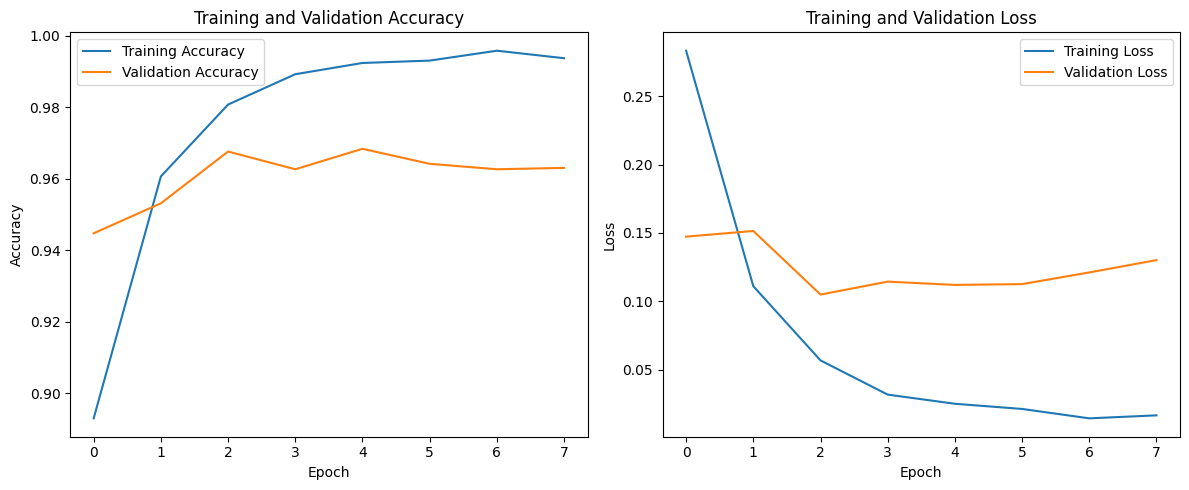


--- Proses Selesai ---


In [9]:
print("\n--- Membangun Arsitektur Model Biner ---")
model = Sequential()
model.add(Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=EMBEDDING_DIM,
    input_length=MAX_LENGTH
))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(GRU(64)))
model.add(Dropout(0.5)) 
model.add(Dense(1, activation='sigmoid'))

# Compile Model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
print(model.summary())

# Siapkan Callback (EarlyStopping)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Melatih Model
print("\n--- Memulai Pelatihan Model Biner ---")
history = model.fit(
    X_train_pad,
    Y_train,         # Gunakan label 1D (0 dan 1)
    epochs=20,       # Tetapkan 20, biarkan EarlyStopping yg menghentikan
    batch_size=64,   # Batch size 64 standar
    validation_data=(X_test_pad, Y_test), # Gunakan label 1D
    callbacks=[early_stop]
)

# Evaluasi Model
print("\n--- Hasil Evaluasi Model Biner ---")
loss, accuracy = model.evaluate(X_test_pad, Y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Plot Hasil Training
print("\nMembuat plot histori training...")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

print("\n--- Proses Selesai ---")

# Inference

In [10]:
reviews_baru = [
    "Update terbaru bikin game jadi lancar jaya!", 
    "Gamenya sih seru, tapi sering banget error pas mau masuk.",
    "tolong dong bug nya diperbaiki, masa tiap main mental terus",
    "Grafiknya makin bagus, suka banget!", 
    "biasa aja gamenya."
]

# Siapkan Nama Label
label_names = ['Negatif', 'Positif']

print("\n--- HASIL INFERENSI PADA DATA BARU ---")

# Loop Melalui Setiap Kalimat
for review in reviews_baru:
    print(f"\nInput Teks: '{review}'")
    
    # preprocessing
    processed_text = review.lower()
    processed_text = re.sub(r'(.)\1{2,}', r'\1', processed_text) # Hapus elongasi
    processed_text = re.sub(r'[^a-zA-Z\s]', '', processed_text) # Hapus non-huruf
    processed_text = processed_text.strip()
    
    # b. Tokenisasi & Normalisasi Slang & Stopword
    tokens = word_tokenize(processed_text)
    cleaned_tokens = []
    for word in tokens:
        if word in normalization_dict:
             word = normalization_dict[word]
        if len(word) > 2 and word not in stop_words: # Contoh filter
             cleaned_tokens.append(word)
    processed_text = " ".join(cleaned_tokens)

    # Stemming
    processed_text = stemmer.stem(processed_text)

    print(f"Teks Bersih: '{processed_text}'") # Tampilkan hasil cleaning
            
    # Ubah ke Sequence dan Lakukan Padding
    seq = tokenizer.texts_to_sequences([processed_text])
    pad = pad_sequences(seq, maxlen=MAX_LENGTH, padding='post', truncating='post')
    
    # Lakukan Prediksi
    # Output sigmoid adalah satu angka antara 0 dan 1
    pred_score = model.predict(pad)[0][0] 
    
    # Tentukan Label Kategorikal
    pred_index = 1 if pred_score > 0.5 else 0
    predicted_label = label_names[pred_index]
    
    # Tampilkan hasil
    print(f"Skor Prediksi: {pred_score:.4f}")
    print(f"Prediksi Sentimen: ---> **{predicted_label}**")
    print("-" * 30)


--- HASIL INFERENSI PADA DATA BARU ---

Input Teks: 'Update terbaru bikin game jadi lancar jaya!'
Teks Bersih: 'update baru bikin game lancar jaya'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
Skor Prediksi: 0.9997
Prediksi Sentimen: ---> **Positif**
------------------------------

Input Teks: 'Gamenya sih seru, tapi sering banget error pas mau masuk.'
Teks Bersih: 'gamenya sih seru ganggu pas masuk'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Skor Prediksi: 0.7939
Prediksi Sentimen: ---> **Positif**
------------------------------

Input Teks: 'tolong dong bug nya diperbaiki, masa tiap main mental terus'
Teks Bersih: 'tolong virus nya baik main mental'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Skor Prediksi: 1.0000
Prediksi Sentimen: ---> **Positif**
------------------------------

Input Teks: 'Grafiknya makin bagus, suka banget!'
Teks Bersih: 'grafik bagus suka'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Skor Prediksi: 0.9998
Prediksi Sentimen: ---> **Positif**
------------------------------

Input Teks: